# 「プチ」勉強会 20230909
* 今回は、実践課題「自社商品の購買顧客を予測しよう！職種、教育水準、ローンの有無などのデータを利用」の探索。
* これも二値分類問題だが、なにげに難しい要素がある。それは不均衡データであるということ。<br>
不均衡データ対策としてはオーバーサンプリングやアンダーサンプリングがありそれも試したが、StraitifiKFoldが重宝した。
* スコアは記録の残っている0.95も意識して取り組んだ。わりと汎化性能もあるモデルに仕上がったと思う<br>
* 新しい試みとしては、SMOTEなどのリサンプリングとグリッドサーチ。LiteGBMのパラメータを初めて弄った。<br>
あと、先週ちょっと齧ったSHAPを具体的に活用したほか、NNモデルをいろいろ弄ってみた。

## 今回取り組んでみたこと
1. 利きの大きい特徴量がdurationしかないので結構苦労した。<br>
```
   ・真陽性が12%弱しかない不均衡データなので、accuracyはせいぜい90%プラスアルファしか出ない。
   ・するとaucはよほど白黒はっきりした分布でない限りaccuracy以上にはなりにくいが、ハイスコアが0.95なのでちょっと頑張ってみた。
   ・基本方針としてはノイズ覚悟で特徴量を量産してあとから重要度順に絞り込むこととした。これで0.93台後半。
   ・IDを利用して何番目の何月といった情報を加えることで0.949が出た。パラメータを弄れば0.95も十分可能と思うが、本件はこれで十分。
   ・なお、解説動画でIDから年情報が得られると言っていたが、具体的な年までは確認できる情報が見当たらなかった。
```
2. 今回も新しい手法にいろいろ挑戦してみた。<br>
```
   ・不均衡データ対策としてのリサンプリングをオーバーサンプリングとアンダーサンプリングをパイプラインで結んで行う手法を覚えた。
   ・学習曲線ツールの分割戦略にStraitifiKFoldをビルトインするやり方を覚えた。
   ・NNの過学習対策でdropoutの調整のほか、正則化項目の追加や早期終了条件を設定するやり方を覚えた。
   ・NN特徴量の抽出は前回もやったが、各Dense層から別々に抽出して合算するやり方も覚えた。
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import shap
from metric_plotter import MetricPlotter

sns.set(style='white')
import japanize_matplotlib

import warnings
warnings.filterwarnings('ignore')


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\portugal_bank\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\portugal_bank\\test.csv')

## 概観

In [3]:
display(df.info())
display(df.head())
display(df_test.info())
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40211 entries, 0 to 40210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         40211 non-null  int64 
 1   age        40211 non-null  int64 
 2   job        40211 non-null  object
 3   marital    40211 non-null  object
 4   education  40211 non-null  object
 5   default    40211 non-null  object
 6   balance    40211 non-null  int64 
 7   housing    40211 non-null  object
 8   loan       40211 non-null  object
 9   contact    40211 non-null  object
 10  day        40211 non-null  int64 
 11  month      40211 non-null  object
 12  duration   40211 non-null  int64 
 13  campaign   40211 non-null  int64 
 14  pdays      40211 non-null  int64 
 15  previous   40211 non-null  int64 
 16  poutcome   40211 non-null  object
 17  y          40211 non-null  object
dtypes: int64(8), object(10)
memory usage: 5.5+ MB


None

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
4,6,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5000 non-null   int64 
 1   age        5000 non-null   int64 
 2   job        5000 non-null   object
 3   marital    5000 non-null   object
 4   education  5000 non-null   object
 5   default    5000 non-null   object
 6   balance    5000 non-null   int64 
 7   housing    5000 non-null   object
 8   loan       5000 non-null   object
 9   contact    5000 non-null   object
 10  day        5000 non-null   int64 
 11  month      5000 non-null   object
 12  duration   5000 non-null   int64 
 13  campaign   5000 non-null   int64 
 14  pdays      5000 non-null   int64 
 15  previous   5000 non-null   int64 
 16  poutcome   5000 non-null   object
dtypes: int64(8), object(9)
memory usage: 664.2+ KB


None

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
1,19,60,retired,married,primary,no,60,yes,no,unknown,5,may,219,1,-1,0,unknown
2,25,40,retired,married,primary,no,0,yes,yes,unknown,5,may,181,1,-1,0,unknown
3,29,46,management,single,secondary,no,-246,yes,no,unknown,5,may,255,2,-1,0,unknown
4,35,51,management,married,tertiary,no,10635,yes,no,unknown,5,may,336,1,-1,0,unknown


In [4]:
display(df.describe())
display(df.describe(include='object'))
display(df_test.describe())
display(df_test.describe(include='object'))

,ID,age,balance,day,duration,campaign,pdays,previous
count,40211.000000,40211.000000,40211.000000,40211.000000,40211.000000,40211.000000,40211.000000,40211.000000
mean,22624.703788,40.932208,1369.058442,15.809480,258.614459,2.754744,40.294372,0.585039
std,13032.800177,10.621005,3063.726303,8.330412,259.249038,3.102956,100.240920,2.366232
min,1.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,11345.500000,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,22683.000000,39.000000,450.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,33891.500000,48.000000,1433.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,45211.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,40211,40211,40211,40211,40211,40211,40211,40211,40211,40211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,8642,24160,20624,39488,22335,33790,26088,12254,32855,35499


,ID,age,balance,day,duration,campaign,pdays,previous
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,22455.580400,40.968400,1307.694600,15.781800,254.533000,2.837000,39.421400,0.542400
std,13200.703911,10.601711,2887.471853,8.259167,243.237157,3.057368,99.228538,1.716622
min,4.000000,19.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,10977.750000,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,21885.000000,39.000000,438.000000,16.000000,179.000000,2.000000,-1.000000,0.000000
75%,34135.000000,49.000000,1379.750000,21.000000,321.000000,3.000000,-1.000000,0.000000
max,45199.000000,93.000000,66653.000000,31.000000,3253.000000,41.000000,831.000000,37.000000


,job,marital,education,default,housing,loan,contact,month,poutcome
count,5000,5000,5000,5000,5000,5000,5000,5000,5000
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,1090,3054,2578,4908,2795,4177,3197,1512,4104


## EDA（データ探索）

```
y          :定額預金申し込み有無（1:あり, 0:なし）
ID         :インデックスとして使用
age        :年齢
job        :職種
marital    :未婚/既婚
education  :教育水準
default    :クレジットの支払い遅延の有無（yes, no）
balance    :年間平均残高（€）
housing    :住宅ローンの有無（yes, no）
loan       :個人ローンの有無（yes, no）
contact    :連絡方法
day        :最終接触日
month      :最終接触月
duration   :最終接触時間（秒）
campaign   :現キャンペーンにおける接触回数
pdays      :前キャンペーン接触後からの経過日数
previous   :現キャンペーン以前までに顧客に接触した回数
poutcome   :前回のキャンペーンの成果
```

<Axes: xlabel='day', ylabel='ID'>

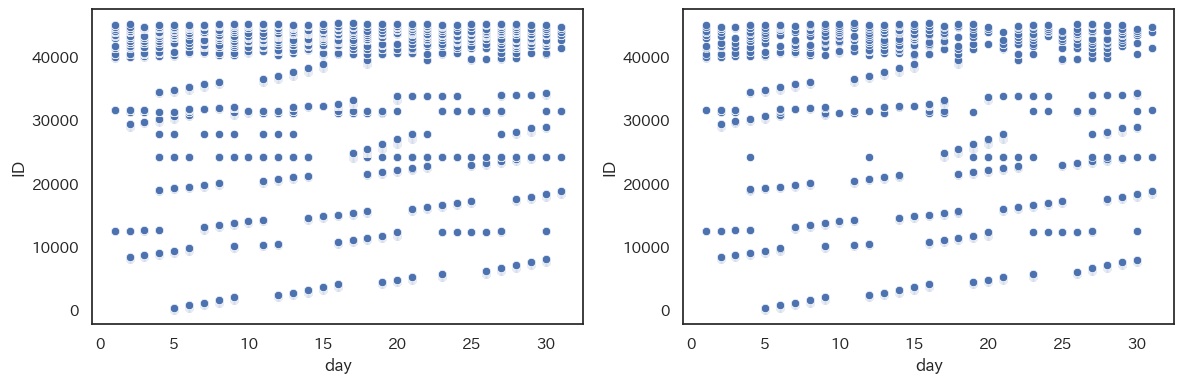

In [5]:
# ID

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
sns.scatterplot(df, x='day', y='ID', ax=ax1)
sns.scatterplot(df_test, x='day', y='ID', ax=ax2)

# IDとdayに明確な関係があることがわかるが、年を特定できるデータは見当たらない
# 何回目の5月といった分類で対応する

In [6]:
# y (目的変数)

df['y'] = df['y'].replace(['yes', 'no'], [1, 0])
display(pd.DataFrame({
    'count': df['y'].value_counts(),
    'proportion': df['y'].value_counts(normalize=True)
}))

df['y'] = df['y'].replace(['yes', 'no'], [1, 0])

# かなり不均衡なデータ

,count,proportion
0,35499,0.882818
1,4712,0.117182


,sum,count,mean
age_3d,,,
young,289,1192,0.242450
middle,3986,37964,0.104994
old,437,1055,0.414218


<Axes: xlabel='age_3d', ylabel='count'>

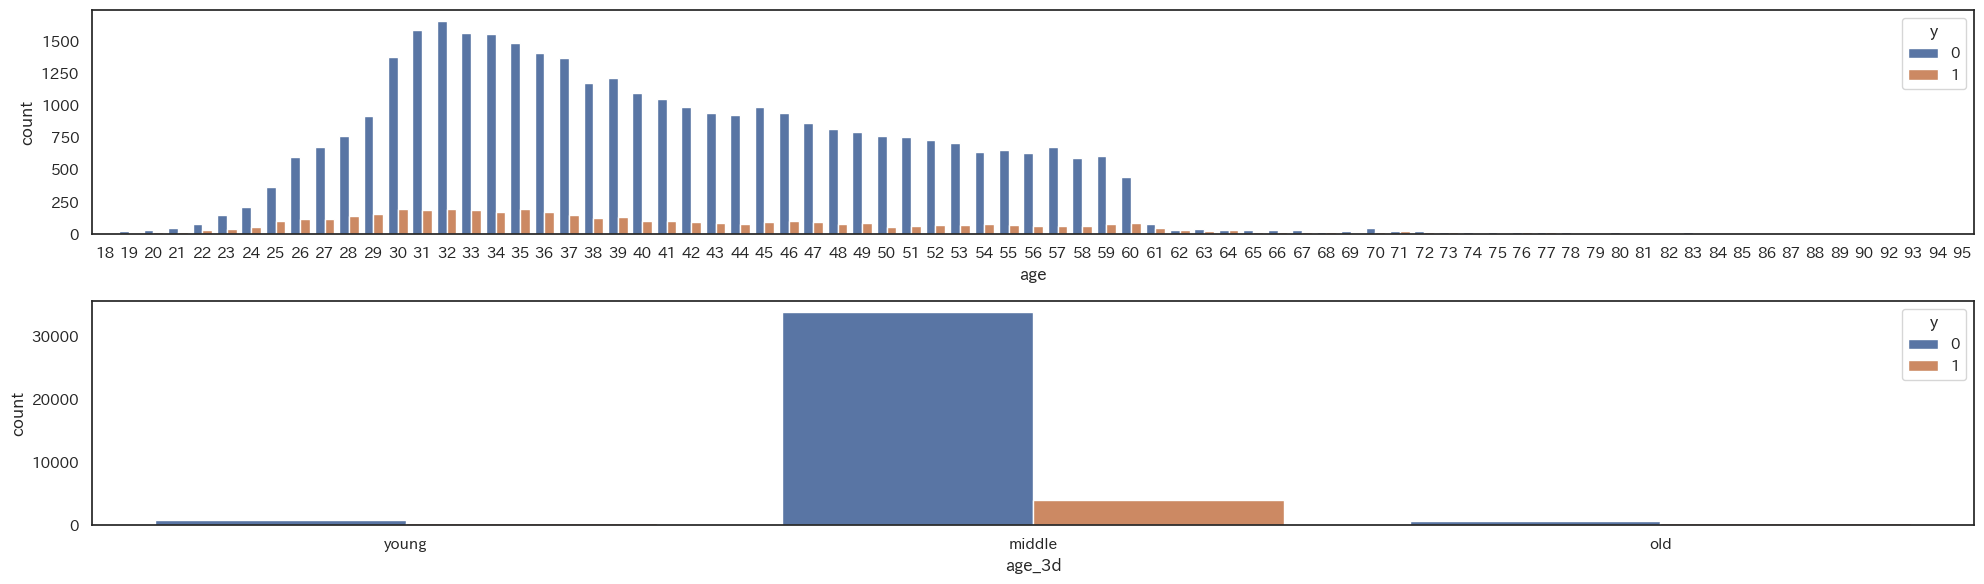

In [7]:
# age

df['age_3d'] = pd.cut(df['age'], [0, 25, 60, 100], labels=['young', 'middle', 'old'])
df_test['age_3d'] = pd.cut(df_test['age'], [0, 25, 60, 100], labels=['young', 'middle', 'old'])
display(df.groupby('age_3d')['y'].agg(['sum', 'count', 'mean']))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), tight_layout=True)
sns.countplot(df, x='age', hue='y', ax=ax1)
sns.countplot(df, x='age_3d', hue='y', ax=ax2)

# 若者とシニアの契約率が高い

,sum,count,mean
job,,,
admin.,561,4554,0.123188
blue-collar,631,8642,0.073016
entrepreneur,112,1321,0.084784
housemaid,92,1097,0.083865
management,1155,8458,0.136557
retired,450,2006,0.224327
self-employed,169,1406,0.120199
services,333,3676,0.090588
student,235,837,0.280765


,sum,count,mean
job_2d,,,
0,4027,37368,0.107766
1,685,2843,0.240943


<Axes: xlabel='job_2d', ylabel='count'>

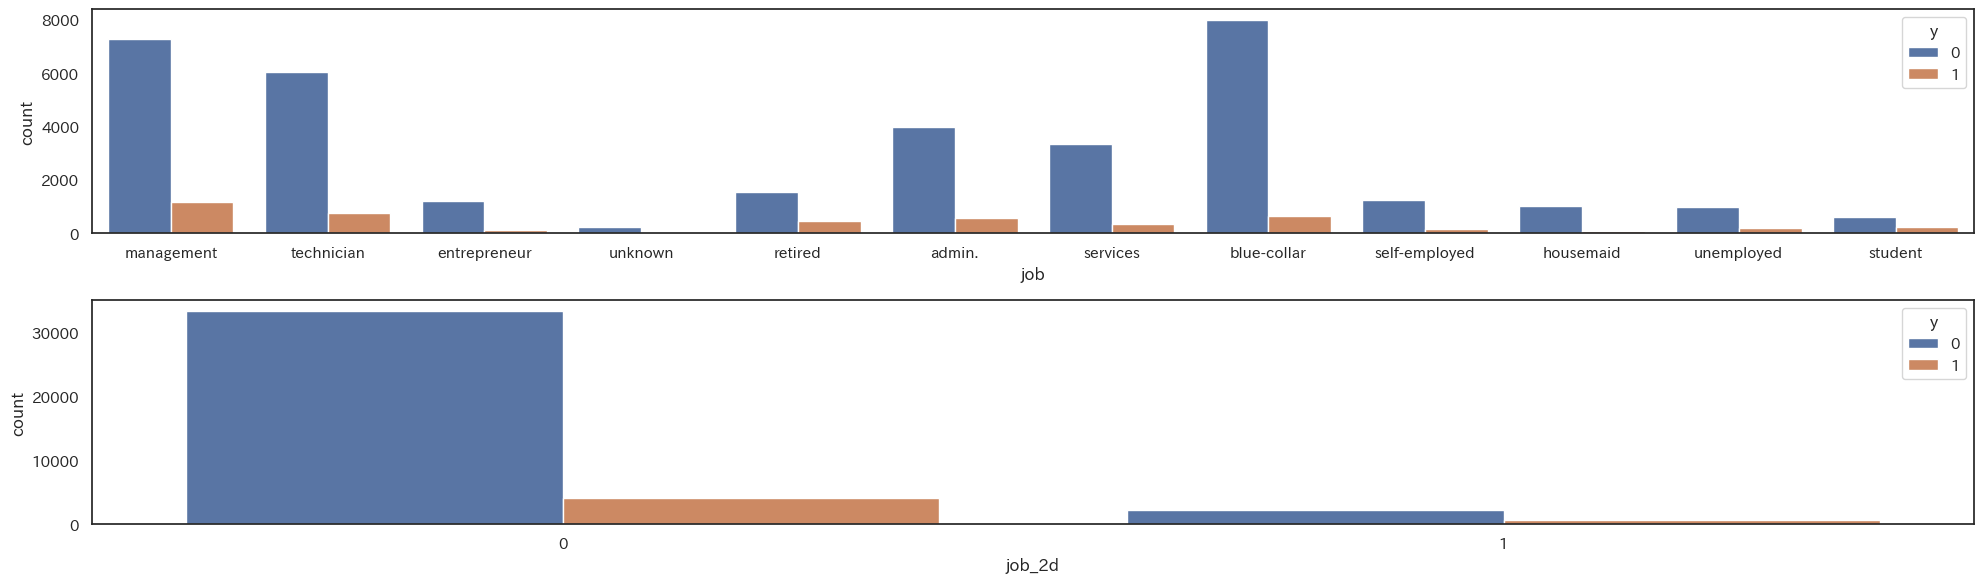

In [8]:
# job

df['job_2d'] = df['job'].apply(lambda x: 1 if (x=='student' or x=='retired') else 0)
df_test['job_2d'] = df_test['job'].apply(lambda x: 1 if (x=='student' or x=='retired') else 0)

display(df.groupby('job')['y'].agg(['sum', 'count', 'mean']))
display(df.groupby('job_2d')['y'].agg(['sum', 'count', 'mean']))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), tight_layout=True)
sns.countplot(df, x='job', hue='y', ax=ax1)
sns.countplot(df, x='job_2d', hue='y', ax=ax2)

# studentとretiredが比較的高い

,sum,count,mean
marital,,,
divorced,558,4634,0.120414
married,2458,24160,0.101738
single,1696,11417,0.148550


<Axes: xlabel='marital', ylabel='count'>

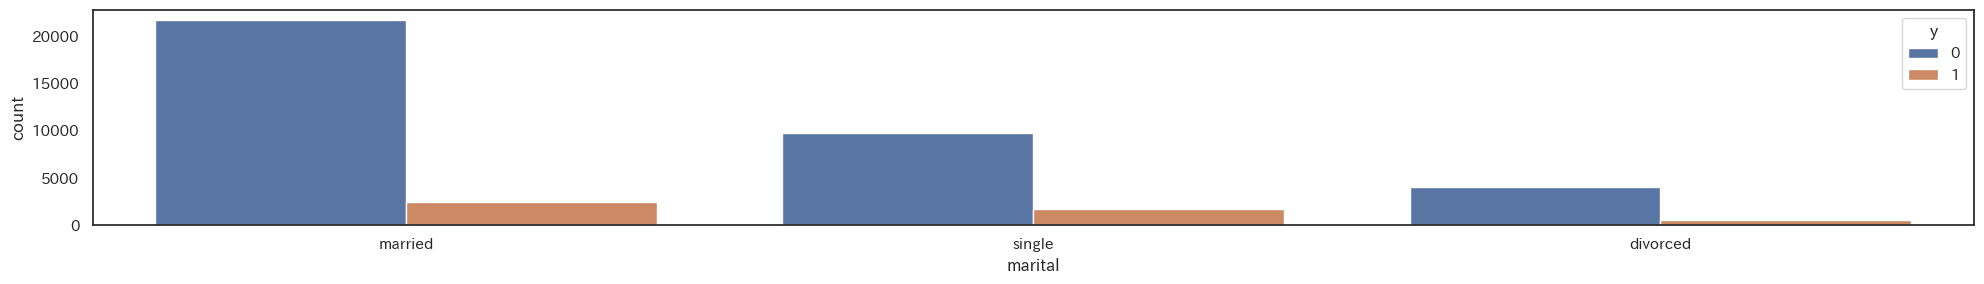

In [9]:
# marital

display(df.groupby('marital')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='marital', hue='y', ax=ax)

# singleの契約率がやや高い

,sum,count,mean
education,,,
primary,534,6082,0.087800
secondary,2181,20624,0.105751
tertiary,1776,11853,0.149835
unknown,221,1652,0.133777


<Axes: xlabel='education', ylabel='count'>

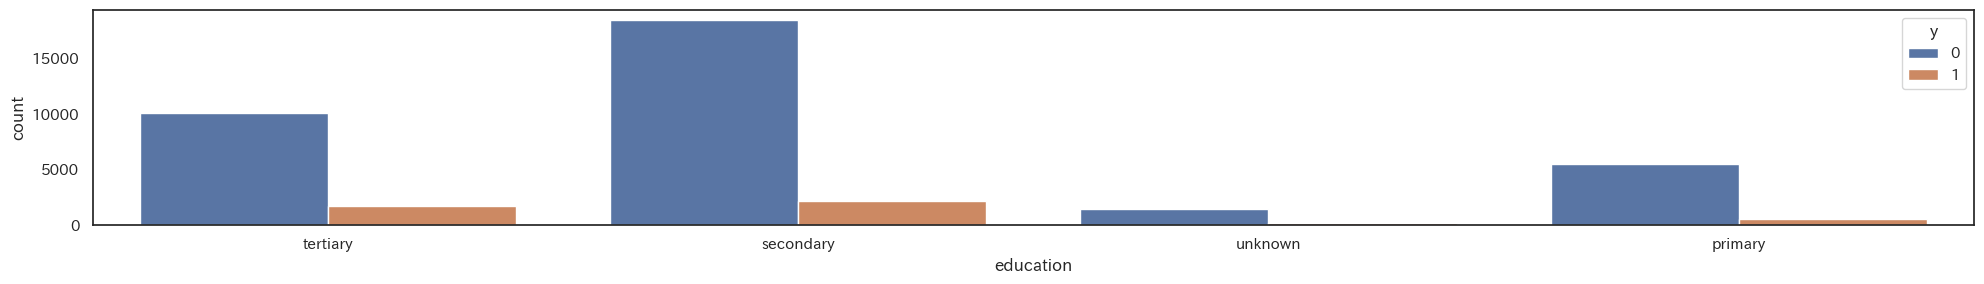

In [10]:
# education

display(df.groupby('education')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='education', hue='y', ax=ax)

# 教育水準と契約率の高さに正の相関がみられる

,sum,count,mean
default,,,
no,4667,39488,0.118188
yes,45,723,0.062241


<Axes: xlabel='default', ylabel='count'>

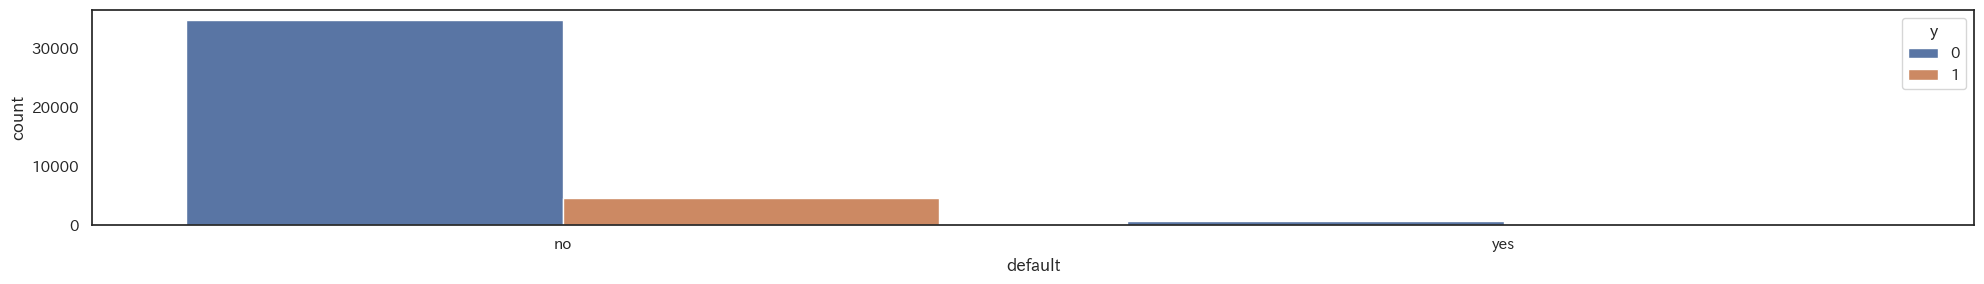

In [11]:
# default

display(df.groupby('default')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='default', hue='y', ax=ax)

# クレジット支払い遅延者の契約率は低い（但し数は少ない）

,sum,count,mean
balance_qcut5,,,
0,561,8082,0.069414
1,820,8022,0.102219
2,955,8040,0.118781
3,1058,8025,0.131838
4,1318,8042,0.163890


<Axes: xlabel='log_balance', ylabel='Count'>

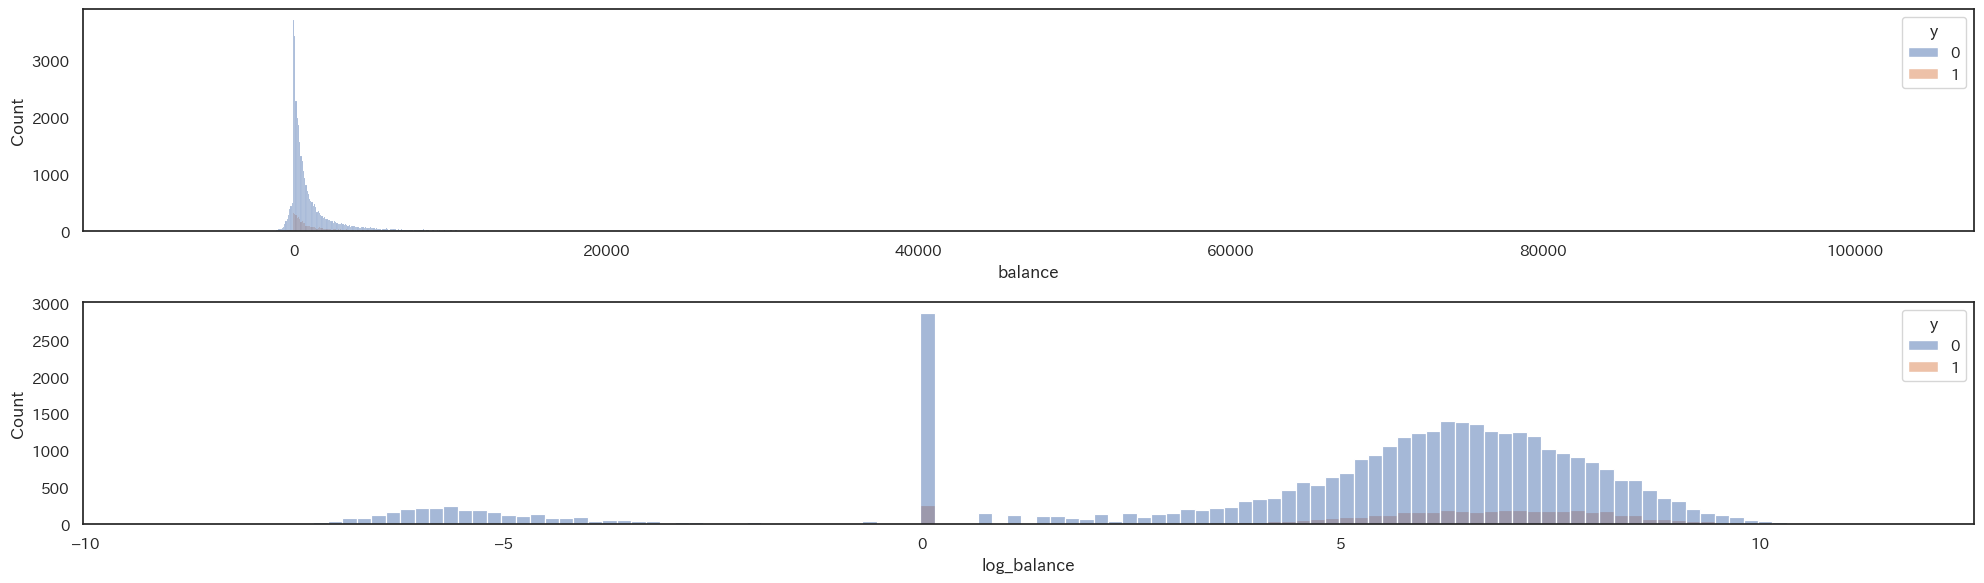

In [12]:
# balance

df['balance_qcut5'] = pd.qcut(df['balance'], 5, labels=[0, 1, 2, 3, 4])
df_test['balance_qcut5'] = pd.qcut(df_test['balance'], 5, labels=[0, 1, 2, 3, 4])
df['log_balance'] = np.sign(df['balance']) * np.log(np.abs(df['balance']) + 1)
df_test['log_balance'] = np.sign(df_test['balance']) * np.log(np.abs(df_test['balance']) + 1)

display(df.groupby('balance_qcut5')['y'].agg(['sum', 'count', 'mean']))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), tight_layout=True)
sns.histplot(df, x='balance', hue='y', ax=ax1)
sns.histplot(df, x='log_balance', hue='y', ax=ax2)

# 預金量が多いほど契約率が高い


,sum,count,mean
housing,,,
no,2994,17876,0.167487
yes,1718,22335,0.076920


<Axes: xlabel='housing', ylabel='count'>

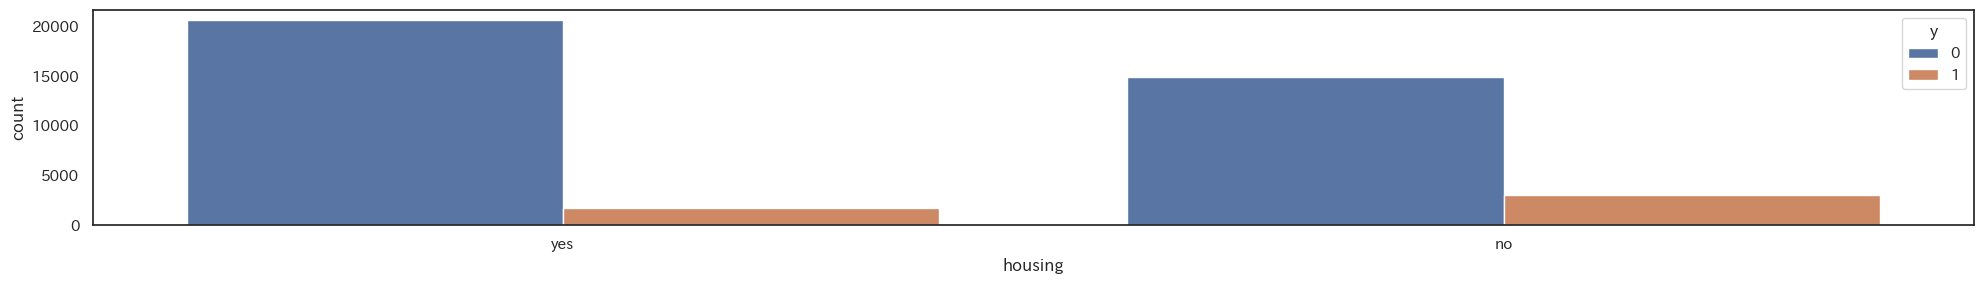

In [13]:
# housing

display(df.groupby('housing')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='housing', hue='y', ax=ax)

# 住宅ローン有の契約率は低い

,sum,count,mean
loan,,,
no,4283,33790,0.126753
yes,429,6421,0.066812


<Axes: xlabel='loan', ylabel='count'>

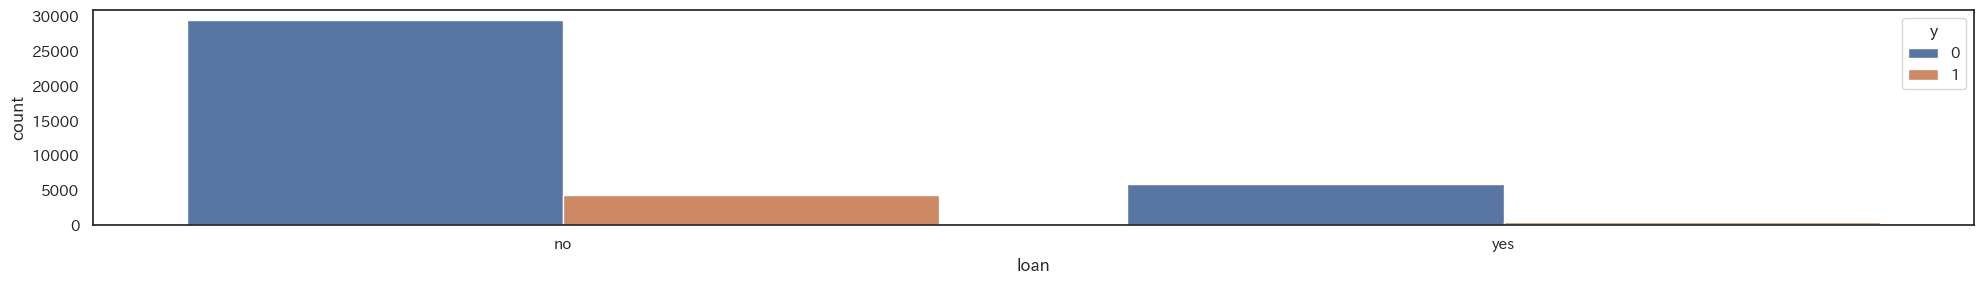

In [14]:
# loan

display(df.groupby('loan')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='loan', hue='y', ax=ax)

# 個人ローン有の契約率も低い

,sum,count,mean
contact,,,
cellular,3904,26088,0.149647
telephone,343,2613,0.131267
unknown,465,11510,0.040400


<Axes: xlabel='contact', ylabel='count'>

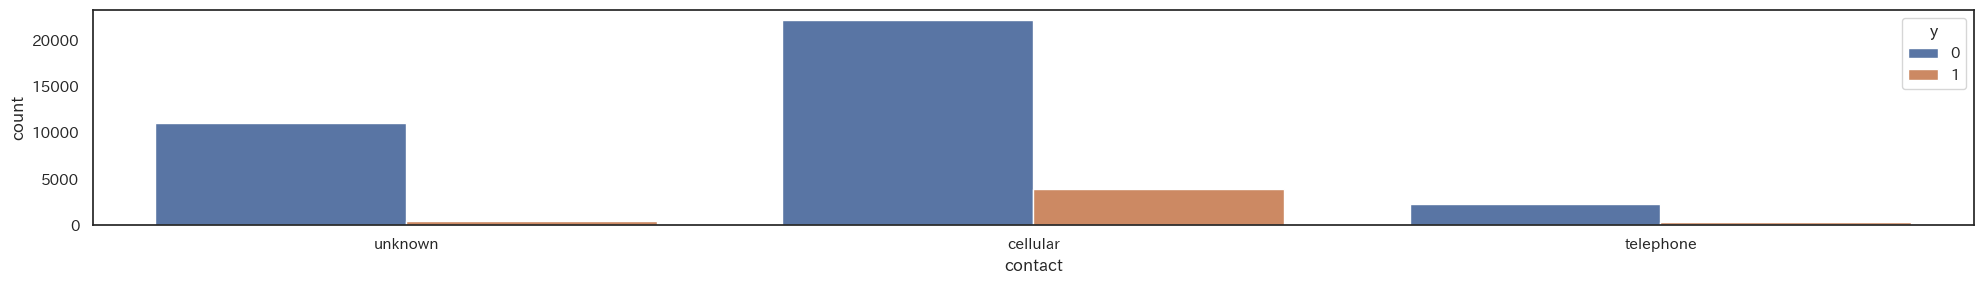

In [15]:
# contact

display(df.groupby('contact')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='contact', hue='y', ax=ax)

# 連絡方法不明者の契約率はとても低い

,sum,count,mean
sum,1.000000,0.643578,0.018981
count,0.643578,1.000000,-0.636506
mean,0.018981,-0.636506,1.000000


<Axes: xlabel='day', ylabel='count'>

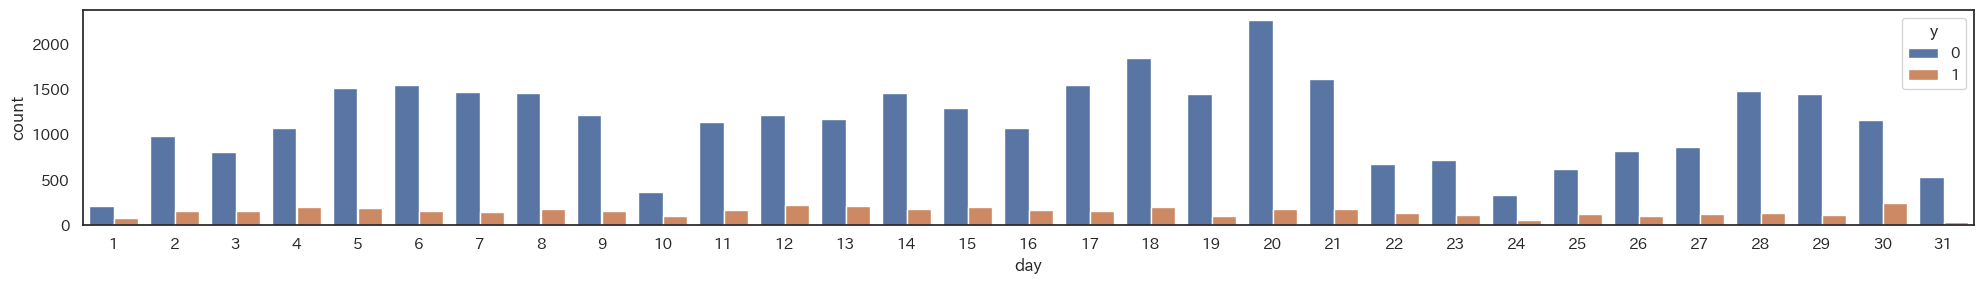

In [16]:
# day

df_day = df.groupby('day')['y'].agg(['sum', 'count', 'mean'])
display(df_day.corr())

fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='day', hue='y', ax=ax)

# 最終接触日は日にちにより傾向がみられるが、契約数との相関は必ずしも高くない


,sum,count,mean
sum,1.000000,0.914313,-0.660381
count,0.914313,1.000000,-0.694883
mean,-0.660381,-0.694883,1.000000


<Axes: xlabel='month', ylabel='count'>

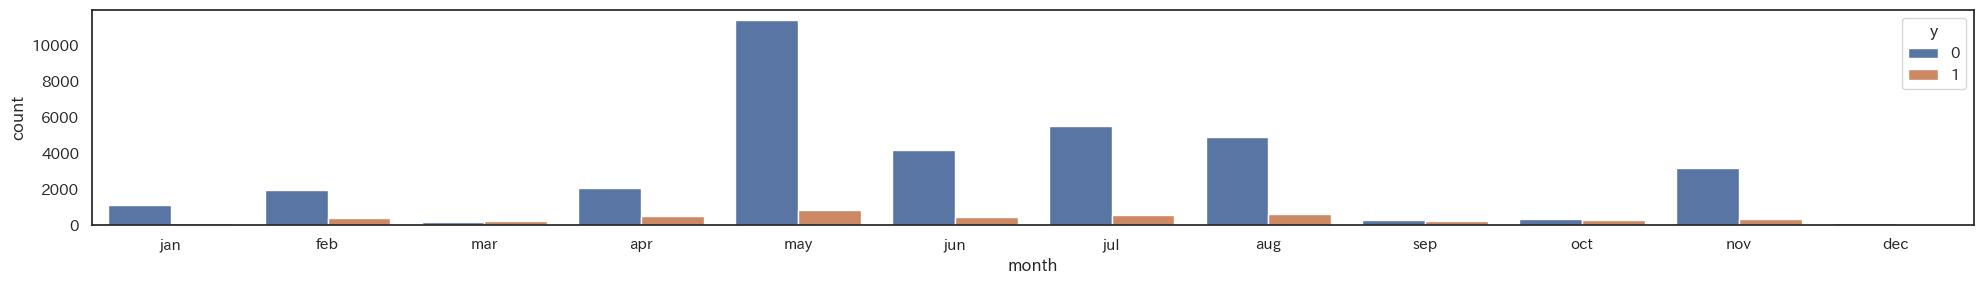

In [17]:
# month

df_month = df.groupby('month')['y'].agg(['sum', 'count', 'mean'])
display(df_month.corr())
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='month', hue='y',
              order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ax=ax)

# 最終接触月は5月と続く3カ月に集中している
# 接触回数と契約数はよく相関している

,sum,count,mean
duration_qcut5,,,
0,57,8098,0.007039
1,298,8054,0.037000
2,636,8035,0.079154
3,1050,8004,0.131184
4,2671,8020,0.333042


<Axes: xlabel='log_duration', ylabel='y'>

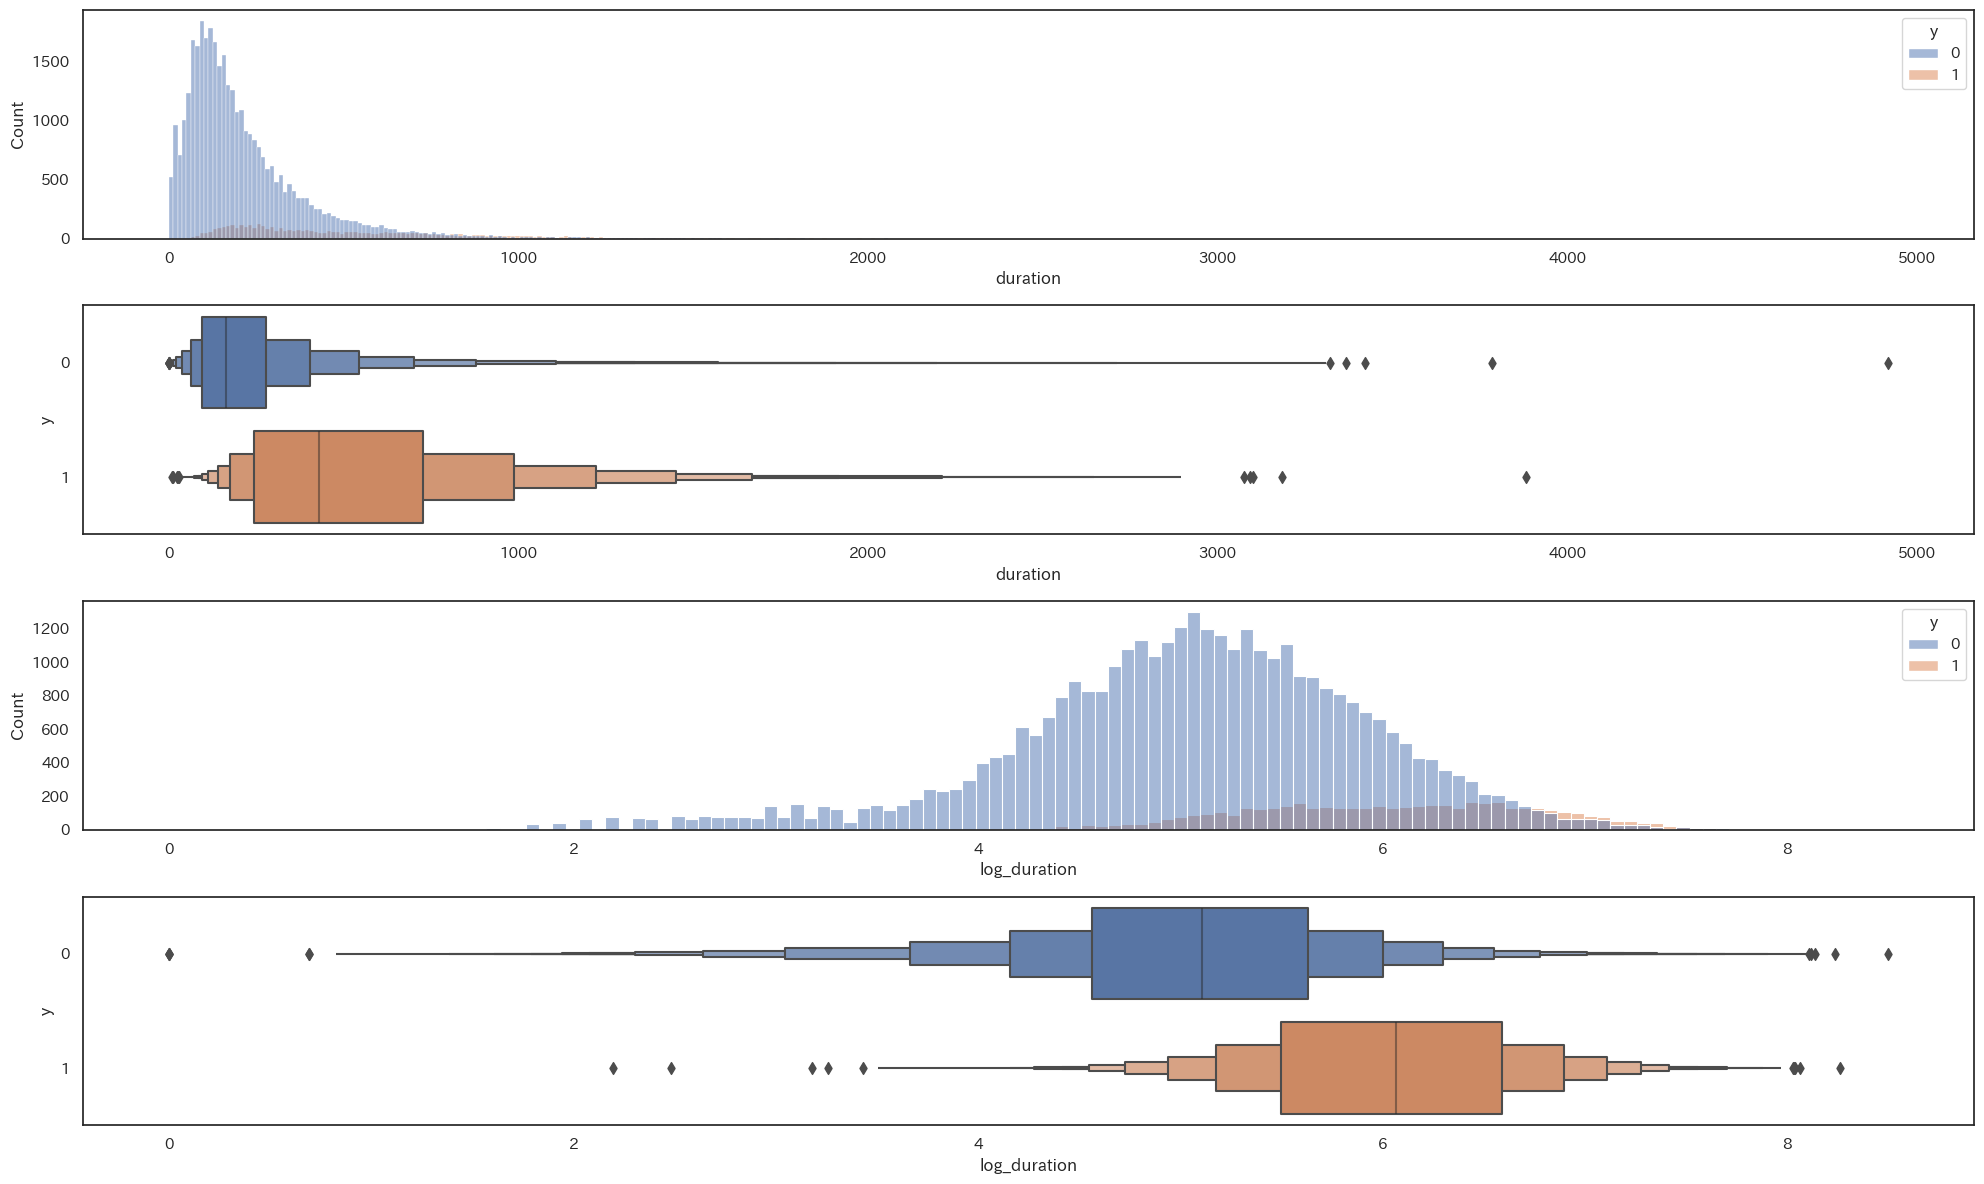

In [18]:
# duration

df['duration_qcut5'] = pd.qcut(df['duration'], 5, labels=[0, 1, 2, 3, 4])
df_test['duration_qcut5'] = pd.qcut(df_test['duration'], 5, labels=[0, 1, 2, 3, 4])
df['log_duration'] = np.log(df['duration'] + 1)
df_test['log_duration'] = np.log(df_test['duration'] + 1)

display(df.groupby('duration_qcut5')['y'].agg(['sum', 'count', 'mean']))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12), tight_layout=True)
sns.histplot(df, x='duration', hue='y', ax=ax1)
sns.boxenplot(df, x='duration', y='y', orient='h', ax=ax2)
sns.histplot(df, x='log_duration', hue='y', ax=ax3)
sns.boxenplot(df, x='log_duration', y='y', orient='h', ax=ax4)

# この特徴量が最も正しく正相関しているように見える

,sum,count,mean
campaign_2d,,,
0,2434,24555,0.099124
1,2278,15656,0.145503


<Axes: xlabel='log_campaign', ylabel='y'>

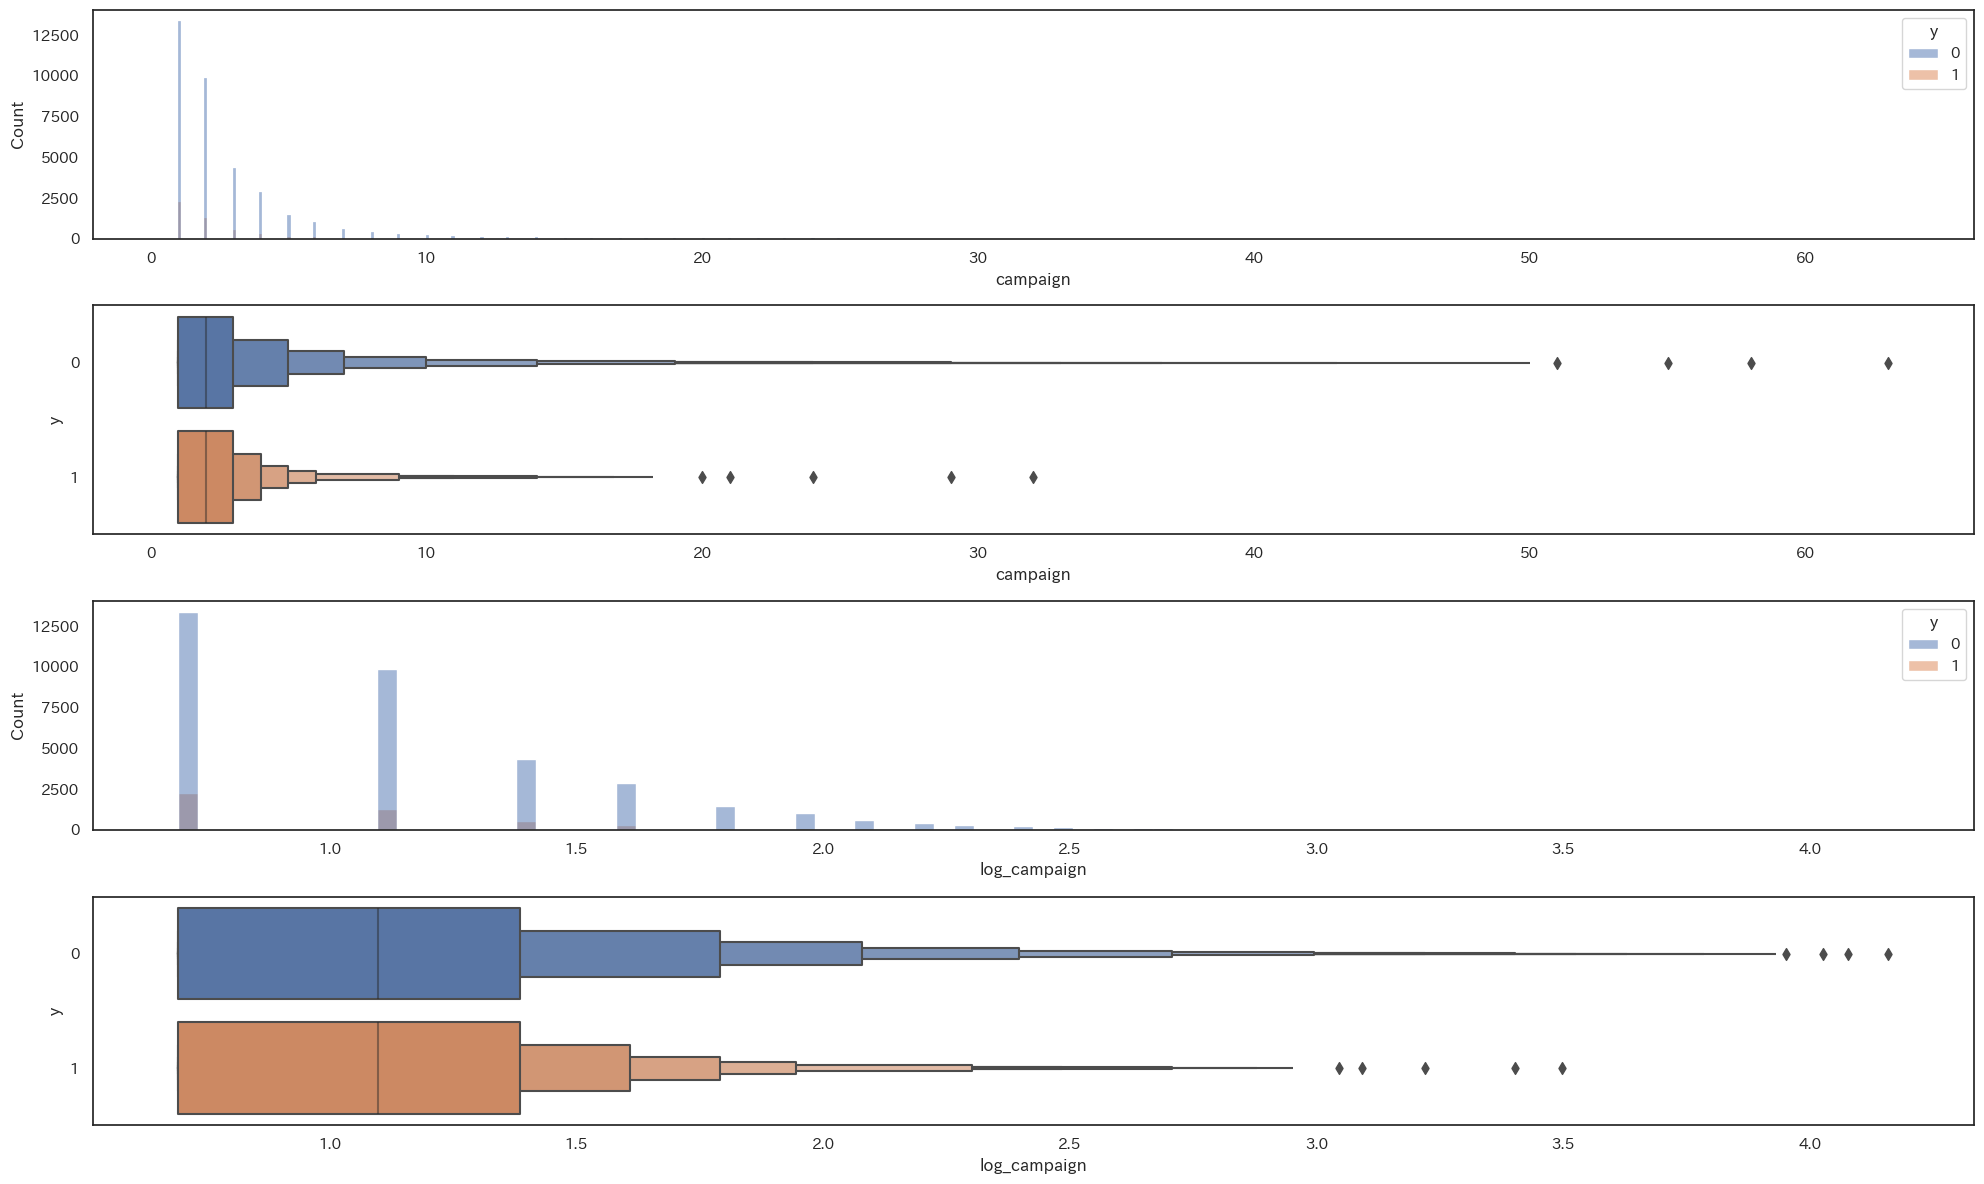

In [19]:
# campaign

df['campaign_2d'] = df['campaign'].apply(lambda x: 1 if x == 1 else 0)
df_test['campaign_2d'] = df_test['campaign'].apply(lambda x: 1 if x == 1 else 0)
df['log_campaign'] = np.log(df['campaign'] + 1)
df_test['log_campaign'] = np.log(df_test['campaign'] + 1)

display(df.groupby('campaign_2d')['y'].agg(['sum', 'count', 'mean']))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12), tight_layout=True)
sns.histplot(df, x='campaign', hue='y', ax=ax1)
sns.boxenplot(df, x='campaign', y='y', orient='h', ax=ax2)
sns.histplot(df, x='log_campaign', hue='y', ax=ax3)
sns.boxenplot(df, x='log_campaign', y='y', orient='h', ax=ax4)

# キャンペーンの接触回数は少ないほど契約率が高い

,pdays_binned,y
0,<0,0.092177
1,0-20,0.142857
2,21-40,0.254237
3,41-80,0.362637
4,81-100,0.503394
5,101-180,0.175316
6,181-200,0.392016
7,201-380,0.107241
8,381-900,0.486486


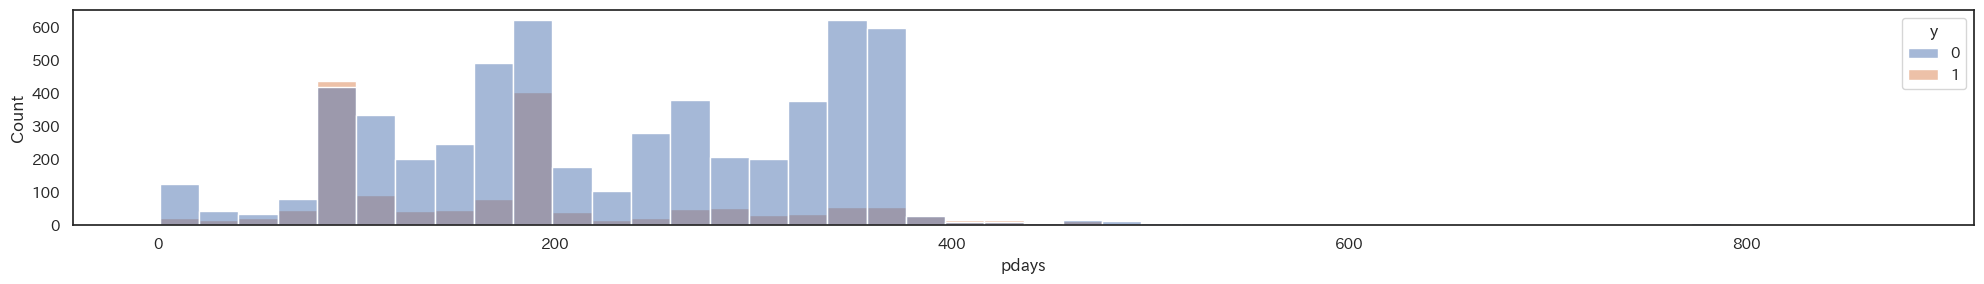

In [20]:
# pdays

df_pdays = df.loc[df['pdays']!=-1, :]
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.histplot(df_pdays, x='pdays', hue='y', ax=ax)

# ビンのエッジとラベルを調整
bins = [-2, -1, 20, 40, 80, 100, 180, 200, 380, 900]
labels = ['<0', '0-20', '21-40', '41-80', '81-100', '101-180', '181-200', 
          '201-380', '381-900']

# ビン分割と陽性率の計算
df['pdays_binned'] = pd.cut(df['pdays'], bins=bins, labels=labels)
df_test['pdays_binned'] = pd.cut(df_test['pdays'], bins=bins, labels=labels)
df.groupby(['pdays_binned'])['y'].mean().reset_index()

# 理由が定かではないが特定レンジでの契約率が非常に高い

,sum,count,mean
previous_2d,,,
0,1684,7361,0.228773
1,3028,32850,0.092177


<Axes: xlabel='previous'>

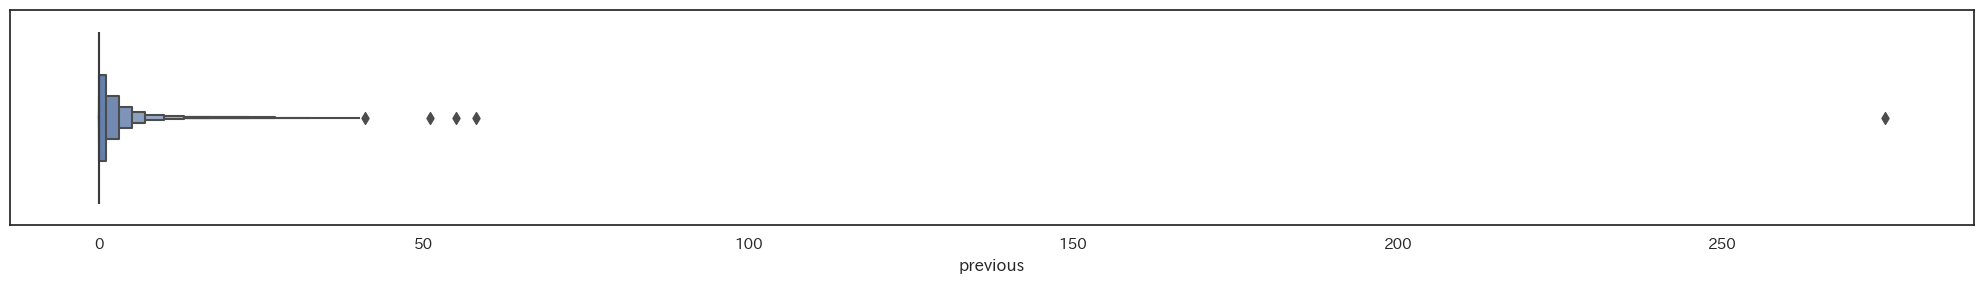

In [21]:
# previous

df['previous_2d'] = df['previous'].apply(lambda x: 1 if x == 0 else 0)
df_test['previous_2d'] = df_test['previous'].apply(lambda x: 0 if x == 1 else 0)
df['log_previous'] = np.log(df['previous']+1)
df_test['log_previous'] = np.log(df_test['previous']+1)
display(df.groupby('previous_2d')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.boxenplot(df, x='previous', hue='y', ax=ax)

# 現キャンペーンまでに接触がないひとの方が契約率が高い

,sum,count,mean
poutcome,,,
failure,549,4388,0.125114
other,268,1638,0.163614
success,865,1330,0.650376
unknown,3030,32855,0.092223


<Axes: xlabel='poutcome', ylabel='count'>

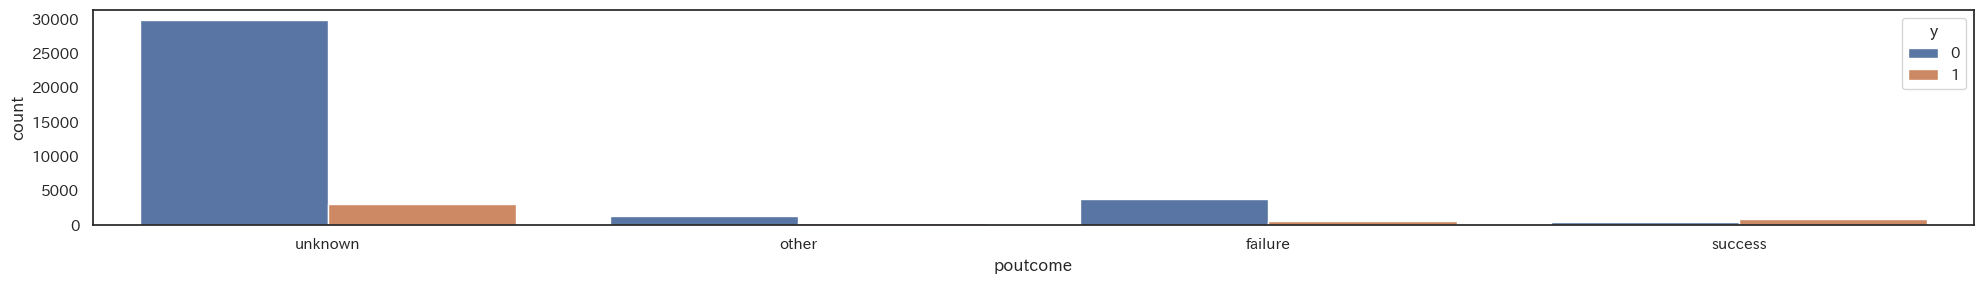

In [22]:
# poutcome

display(df.groupby('poutcome')['y'].agg(['sum', 'count', 'mean']))
fig, ax = plt.subplots(figsize=(20, 3), tight_layout=True)
sns.countplot(df, x='poutcome', hue='y', ax=ax)

# 前回成功者は突出して契約率が高い（当たり前？）

## 前処理、特徴量エンジニアリング

In [23]:
# 特徴量　month_year_count

df_conv = pd.concat([df, df_test])
ID_month = df_conv.groupby(['ID', 'month'])['ID'].count().unstack()
im = []
for i in ID_month.index:
    for m in ID_month.columns:
        if ID_month.loc[i, m] > 0:
            im.append((i, m))

counter = 1
dic_m = {}
for id, mon in im:
    if id == 1:
        pass
    else:
        if mon == 'may' and im[id-2][1] == 'apr':
            counter += 1
    dic_m[id] = counter

df['month_year_count'] = df['ID'].map(dic_m)
df_test['month_year_count'] = df_test['ID'].map(dic_m)

# 5月からスタートして何回目の何月かを特定する

In [24]:
# 特徴量 duration_per_campaign
df['duration_per_campaign'] = df['duration'] / (df['campaign'] + 1)
df_test['duration_per_campaign'] = df_test['duration'] / (df_test['campaign'] + 1)

# 新しい特徴量と y の関係を分析
df.groupby('y')['duration_per_campaign'].agg(['mean', 'std'])

# campaign当たりの接触時間

,mean,std
y,,
0,78.262173,83.641905
1,196.379749,153.806919


In [25]:
# 特徴量 campaign_div_previous
df['campaign_div_previous'] = df['campaign'] / (df['previous'] + 1)
df_test['campaign_div_previous'] = df_test['campaign'] / (df_test['previous'] + 1)

# 前回キャンペーンとの比較

campaign_div_previous          
                   mean       std
y                                
0              2.600656  3.253988
1              1.703398  2.012368

In [26]:
# 特徴量 month_digi（month を数値に変換）
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df['month_digi'] = df['month'].map(month_dict)
df_test['month_digi'] = df_test['month'].map(month_dict)

In [27]:
# 特徴量　weekday

from datetime import datetime
df['weekday'] = df.apply(lambda x: datetime(2020, x['month_digi'], x['day'] ).weekday(), axis=1)
df_test['weekday'] = df_test.apply(lambda x: datetime(2020, x['month_digi'], x['day'] ).weekday(), axis=1)

# 年は特定できないので仮に2020年として曜日別のフラグ（何曜日かはわからない）を取得

In [28]:
# 特徴量 day_duration, month_duration, day_month_duration
df['day_duration'] = df['day'] * df['duration']
df['month_duration'] = df['month_digi'] * df['duration']
df['day_month_duration'] = df['day'] * df['month_digi'] * df['duration']

df_test['day_duration'] = df_test['day'] * df_test['duration']
df_test['month_duration'] = df_test['month_digi'] * df_test['duration']
df_test['day_month_duration'] = df_test['day'] * df_test['month_digi'] * df_test['duration']

# durationがキーなので、関連特徴量を量産

day_duration              month_duration              day_month_duration  \
          mean          std           mean          std               mean   
y                                                                            
0  3450.973182  4037.001424    1343.110257  1485.204010       21352.843094   
1  8312.609932  8299.743183    3375.164898  2922.788365       52542.958404   

                 
            std  
y                
0  28378.335562  
1  59941.182352

In [29]:
# 特徴量 previous_poutcome_interraction

df['previous_poutcome_interaction'] = df['pdays'] * df['previous']
df_test['previous_poutcome_interaction'] = df_test['pdays'] * df_test['previous']


In [30]:
# 特徴量 average_duration_month, duration_deviation

dic_DM = df.groupby('month')['duration'].mean().to_dict()
df['average_duration_month'] = df['month'].map(dic_DM)
df_test['average_duration_month'] = df_test['month'].map(dic_DM)

df['duration_deviation'] = df['duration'] - df['average_duration_month']
df_test['duration_deviation'] = df_test['duration'] - df_test['average_duration_month']

# 月別の平均durationと偏差

In [31]:
# 特徴量 pdays_999, pdays_not999, previous_0

df['pdays_999'] = df['pdays'].apply(lambda x: 1 if x == -1 else 0)
df_test['pdays_999'] = df_test['pdays'].apply(lambda x: 1 if x == -1 else 0)

# 'pdays'が-1でない場合、新しい特徴量を作成（前回のキャンペーンからの経過日数が短い）
df['pdays_not_999'] = df['pdays'].apply(lambda x: 1 if x != -1 else 0)
df_test['pdays_not_999'] = df_test['pdays'].apply(lambda x: 1 if x != -1 else 0)

# 'previous'が0の場合、新しい特徴量を作成（以前のキャンペーンがなかった）
df['previous_0'] = df['previous'].apply(lambda x: 1 if x == 0 else 0)
df_test['previous_0'] = df_test['previous'].apply(lambda x: 1 if x == 0 else 0)


In [32]:
# カテゴリカル変数のOne-Hotエンコーディング
df = pd.get_dummies(df.drop('ID', axis=1), drop_first=True)
df_test = pd.get_dummies(df_test.drop('ID', axis=1), drop_first=True)


In [33]:
df.drop(columns=['balance', 'duration', 'campaign', 'previous'], inplace=True)
df_test.drop(columns=['balance', 'duration', 'campaign', 'previous'], inplace=True)

## 予測と評価

In [34]:

X = df.drop('y', axis=1)
y = df['y']
train_columns = X.columns

# リサンプリング戦略の定義
resampling = Pipeline([
    ('SMOTE', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('RandomUnderSampler', RandomUnderSampler(sampling_strategy=1.0, random_state=42))
])
# 標準化
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=train_columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=train_columns)

# LightGBM
model = lgb.LGBMClassifier()

# Stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 訓練データに対してリサンプリング
    X_train, y_train = resampling.fit_resample(X_train, y_train)

    # モデル訓練と予測
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:, 1]
    scores.append(roc_auc_score(y_test, pred))

mean_auc = sum(scores) / len(scores)
print(f'average auc: {mean_auc}')

average auc: 0.9427598279296703


,0,1,2,3,4,5,6,7,8,9
Training samples,3216,6433,9650,12867,16084,19300,22517,25734,28951,32168
Training score,1.000,0.999,0.995,0.991,0.986,0.983,0.980,0.978,0.976,0.974
Validation score,0.923,0.933,0.936,0.939,0.941,0.943,0.943,0.944,0.944,0.945


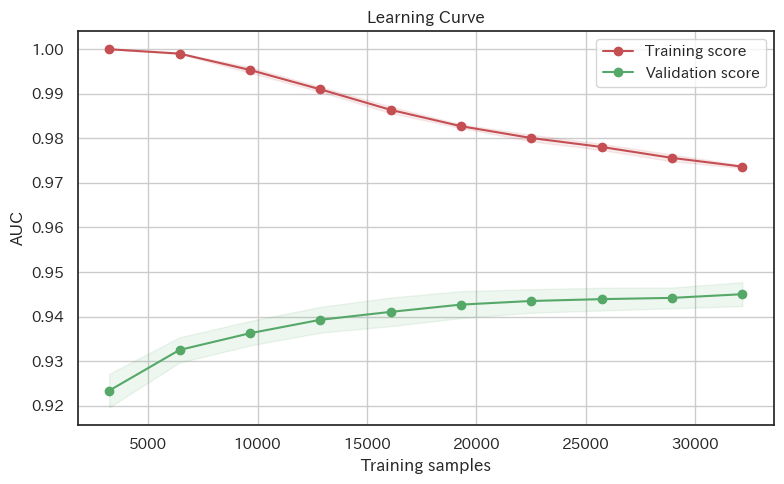

In [35]:
# 学習曲線_1
from sklearn.model_selection import StratifiedKFold
from metric_plotter import MetricPlotter

title = 'Learning Curve'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
estimator = lgb.LGBMClassifier()

plotter = MetricPlotter(estimator=estimator, title=title, metric='auc')
_ = plotter.plot_learning_curve(X, y, cv=cv)

# 分割戦略にStraitifiedKFoldをビルトイン
# Validation scoreは高いがTraining scoreとの乖離が大きい

In [36]:
# feature_importances
pd.DataFrame({'feature_importances':model.feature_importances_},
             index=model.feature_name_).sort_values('feature_importances', ascending=False).head(20)


,feature_importances
duration_per_campaign,171
month_duration,170
day,169
month_year_count,165
weekday,149
log_balance,135
age,134
month_digi,128
day_duration,127
duration_deviation,119


 99%|===================| 28138/28400 [01:37<00:00]        

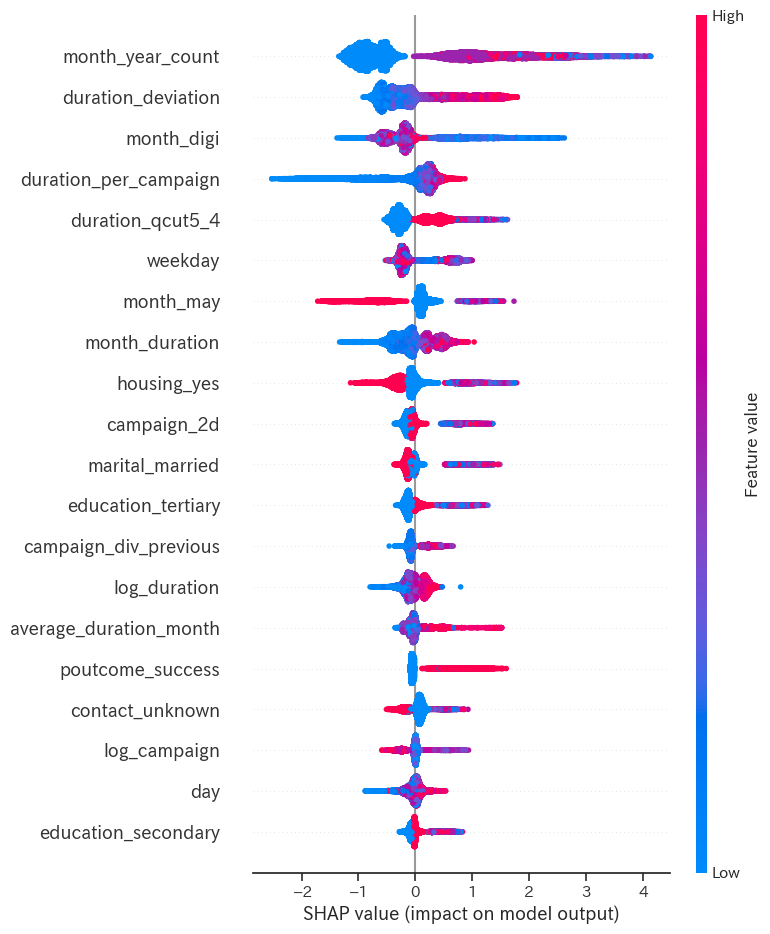

In [37]:
# SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# 要約プロットで重要度の高い特徴量を絞り込む

In [38]:
train_columns

Index(['age', 'day', 'pdays', 'job_2d', 'log_balance', 'log_duration',
       'campaign_2d', 'log_campaign', 'previous_2d', 'log_previous',
       'month_year_count', 'duration_per_campaign', 'campaign_div_previous',
       'month_digi', 'weekday', 'day_duration', 'month_duration',
       'day_month_duration', 'previous_poutcome_interaction',
       'average_duration_month', 'duration_deviation', 'pdays_999',
       'pdays_not_999', 'previous_0', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
      

In [39]:

# 特徴量選択（feature_importanceおよびSHAPの要約プロットから重要度上位20個を選択）

features = [
        'month_year_count',
#       'age',
       'day',
       'pdays',
#       'job_2d',
       'log_balance',
       'log_duration',
       'campaign_2d',
       'log_campaign',
#       'previous_2d',
#       'log_previous',
       'duration_per_campaign',
       'campaign_div_previous',
       'month_digi',
#       'day_duration',
       'month_duration',
       'weekday',
       'day_month_duration',
#       'previous_poutcome_interaction',
       'average_duration_month',
       'duration_deviation',
#       'pdays_999',
#       'pdays_not_999',
#       'previous_0',
#       'job_blue-collar',
#       'job_entrepreneur',
#       'job_housemaid',
#       'job_management',
#       'job_retired',
#       'job_self-employed',
#       'job_services',
#       'job_student',
#       'job_technician',
#       'job_unemployed',
#       'job_unknown',
       'marital_married',
#       'marital_single',
       'education_secondary',
       'education_tertiary',
#       'education_unknown',
#       'default_yes',
       'housing_yes',
#       'loan_yes',
#       'contact_telephone',
       'contact_unknown',
#       'month_aug',
#       'month_dec',
#       'month_feb',
#       'month_jan',
#       'month_jul',
#       'month_jun',
#       'month_mar',
       'month_may',
#       'month_nov',
#       'month_oct',
#       'month_sep',
#       'poutcome_other',
       'poutcome_success',
#       'poutcome_unknown',
#       'age_3d_middle',
#       'age_3d_old',
#       'balance_qcut5_1',
#       'balance_qcut5_2',
#       'balance_qcut5_3',
#       'balance_qcut5_4',
#       'duration_qcut5_1',
#       'duration_qcut5_2',
#       'duration_qcut5_3',
       'duration_qcut5_4',
#       'pdays_binned_0-20',
#       'pdays_binned_21-40',
#       'pdays_binned_41-80',
#       'pdays_binned_81-100',
#       'pdays_binned_101-180',
#       'pdays_binned_181-200',
#       'pdays_binned_201-380',
#       'pdays_binned_381-900'
       ]

In [40]:
# グリッドサーチ（hyperopt:ベイズ最適化モデル）

import hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size=0.2, random_state=42)

# ハイパーパラメータの探索空間を定義
space = {
    'num_leaves': hp.choice('num_leaves', range(20, 150)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 12)),
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10)
}

# 目的関数を定義（roc_auc_scoreを使用）
def objective(params):
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)], 
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=1)], 
        verbose=False
    )
    preds_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds_proba)
    return {'loss': -auc, 'status': STATUS_OK}

# 最適化の実行
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials, verbose=0)
print("Best hyperparameters:", best)


[LightGBM] [Warning] feature_fraction is set=0.6134432792400537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6134432792400537
[LightGBM] [Warning] bagging_fraction is set=0.9108486555921188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108486555921188
[1]	valid_0's binary_logloss: 0.274356
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.245537
[3]	valid_0's binary_logloss: 0.230301
[4]	valid_0's binary_logloss: 0.218321
[5]	valid_0's binary_logloss: 0.212954
[6]	valid_0's binary_logloss: 0.205699
[7]	valid_0's binary_logloss: 0.202505
[8]	valid_0's binary_logloss: 0.200103
[9]	valid_0's binary_logloss: 0.198204
[10]	valid_0's binary_logloss: 0.194862
[11]	valid_0's binary_logloss: 0.193706
[12]	valid_0's binary_logloss: 0.190467
[13]	valid_0's binary_logloss: 0.189637
[14]	valid_0's binary_logloss: 0.188999
[15]	valid_0's binary_logloss: 0.188778
[16]	valid_0's binary_logloss: 0.187005
[17]	va

[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034
[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034
[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034
[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. 

,0,1,2,3,4,5,6,7,8,9
Training samples,3216,6433,9650,12867,16084,19300,22517,25734,28951,32168
Training score,0.967,0.959,0.956,0.954,0.953,0.952,0.952,0.951,0.951,0.951
Validation score,0.928,0.934,0.936,0.938,0.939,0.940,0.941,0.941,0.941,0.942


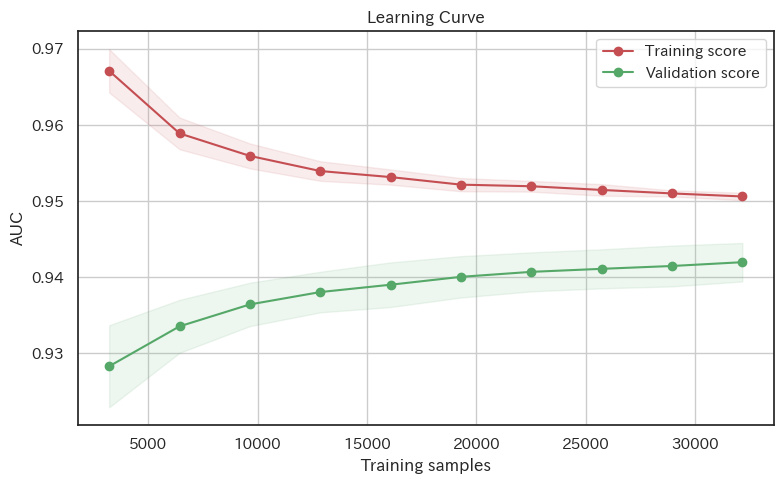

[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034
accuracy: 0.9127191346512495
auc     : 0.945060133335195


In [51]:

# 学習曲線_2
from sklearn.model_selection import StratifiedKFold
from metric_plotter import MetricPlotter

title = 'Learning Curve'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
estimator = lgb.LGBMClassifier(**best)

plotter = MetricPlotter(estimator=estimator, title=title, metric='auc')
_ = plotter.plot_learning_curve(X[features], y, cv=cv)

X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size=0.2, random_state=42)
lgb_model = lgb.LGBMClassifier(**best)
lgb_model = lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
print(f'accuracy: {accuracy_score(y_val, np.round(lgb_pred))}')
print(f'auc     : {roc_auc_score(y_val, lgb_pred)}')


# 特徴量絞り込み後のデータで再確認
# Validation scoreの減少は僅かでTraining scoreとの乖離が縮小

In [42]:
# NNモデルからの特徴量抽出

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

# モデルの定義
NN_model = Sequential([
    Dense(64, activation='relu', input_shape=(X[features].shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# モデルのコンパイル
NN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# EarlyStoppingコールバックのインスタンス化
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

auc_scores = []
X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size=0.2, stratify=y, random_state=42)

# 訓練と予測
NN_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,
             callbacks=[early_stopping])
y_pred = NN_model.predict(X_val).reshape(-1)

print(f'roc: {roc_auc_score(y_val, y_pred)}')

# LightGBMほどのスコアは出ていない

Epoch 1/100
1006/1006 [==============================] - 4s 2ms/step - loss: 0.4018 - auc: 0.8377 - val_loss: 0.2603 - val_auc: 0.9260
Epoch 2/100
1006/1006 [==============================] - 2s 2ms/step - loss: 0.2674 - auc: 0.8996 - val_loss: 0.2258 - val_auc: 0.9311
Epoch 3/100
1006/1006 [==============================] - 3s 3ms/step - loss: 0.2433 - auc: 0.9077 - val_loss: 0.2131 - val_auc: 0.9322
Epoch 4/100
1006/1006 [==============================] - 2s 2ms/step - loss: 0.2348 - auc: 0.9110 - val_loss: 0.2123 - val_auc: 0.9335
Epoch 5/100
1006/1006 [==============================] - 3s 2ms/step - loss: 0.2286 - auc: 0.9145 - val_loss: 0.2088 - val_auc: 0.9335
Epoch 6/100
1006/1006 [==============================] - 2s 2ms/step - loss: 0.2257 - auc: 0.9168 - val_loss: 0.2065 - val_auc: 0.9344
Epoch 7/100
1006/1006 [==============================] - 3s 3ms/step - loss: 0.2260 - auc: 0.9146 - val_loss: 0.2069 - val_auc: 0.9367
Epoch 8/100
1006/1006 [==============================] 

In [43]:
from tensorflow.keras.models import Model

# 既存のNNモデルから、特定の隠れ層の出力を取得する新しいモデルを作成
for i in [-2, -4]:
    intermediate_layer_model = Model(inputs=NN_model.input, outputs=NN_model.layers[i].output)
# 訓練データで新しいモデルを実行して、各層から新しい特徴量を取得
    intermediate_output = intermediate_layer_model.predict(X[features])
    intermediate_output_test = intermediate_layer_model.predict(df_test[features])
# 新しい特徴量をオリジナルのデータセットに追加
    df_scaled_new_features = np.concatenate([X, intermediate_output], axis=1)
    df_test_new_features = np.concatenate([df_test, intermediate_output_test], axis=1)

157/157 [==============================] - 0s 1ms/step


[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034


[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034
[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034
[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034
[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. 

,0,1,2,3,4,5,6,7,8,9
Training samples,3216,6433,9650,12867,16084,19300,22517,25734,28951,32168
Training score,0.975,0.968,0.965,0.962,0.961,0.959,0.958,0.957,0.957,0.956
Validation score,0.943,0.945,0.946,0.946,0.947,0.947,0.948,0.947,0.948,0.948


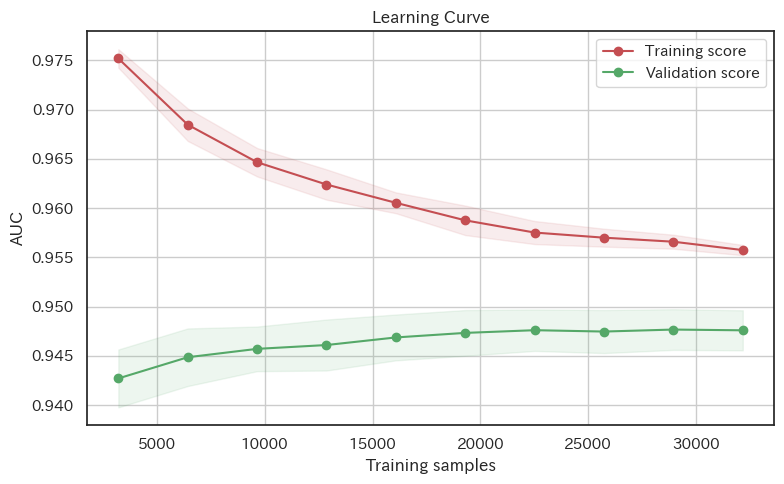

In [44]:
# 学習曲線3（アンサンブル効果）

estimator = lgb.LGBMClassifier(**best)
plotter = MetricPlotter(estimator=estimator, title=title, metric='auc')
_ = plotter.plot_learning_curve(df_scaled_new_features, y, cv=cv)

# NNモデルのパフォーマンスが足らないため期待ほどではない

## 提出用ファイル

In [48]:
# Light GBM

lgb_model = lgb.LGBMClassifier(**best)
lgb_model = lgb_model.fit(df_scaled_new_features, y)
lgb_pred = lgb_model.predict_proba(df_test_new_features)[:,1]
#lgb_model = lgb_model.fit(X[features], y)
#lgb_pred = lgb_model.predict_proba(df_test[features])[:,1]

# 結局、NNモデルの特徴量合成は使わずにLightGBMの改善モデルで評価、提出

[LightGBM] [Warning] feature_fraction is set=0.5881619865957242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881619865957242
[LightGBM] [Warning] bagging_fraction is set=0.731224351065034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.731224351065034


In [46]:
# 7-2 提出用データファイルのセッティング
df_submit = pd.read_csv('C:\\Users\\yuich\\KC_data\\portugal_bank\\sample_submission.csv')
df_submit['y'] = lgb_pred
df_submit.set_index('ID', inplace=True)
df_submit.to_csv('submission.csv')

In [47]:
df_submit

,y
ID,
4,0.001352
19,0.001677
25,0.001645
29,0.001352
35,0.001447
...,...
45159,0.652949
45169,0.827712
45174,0.097018


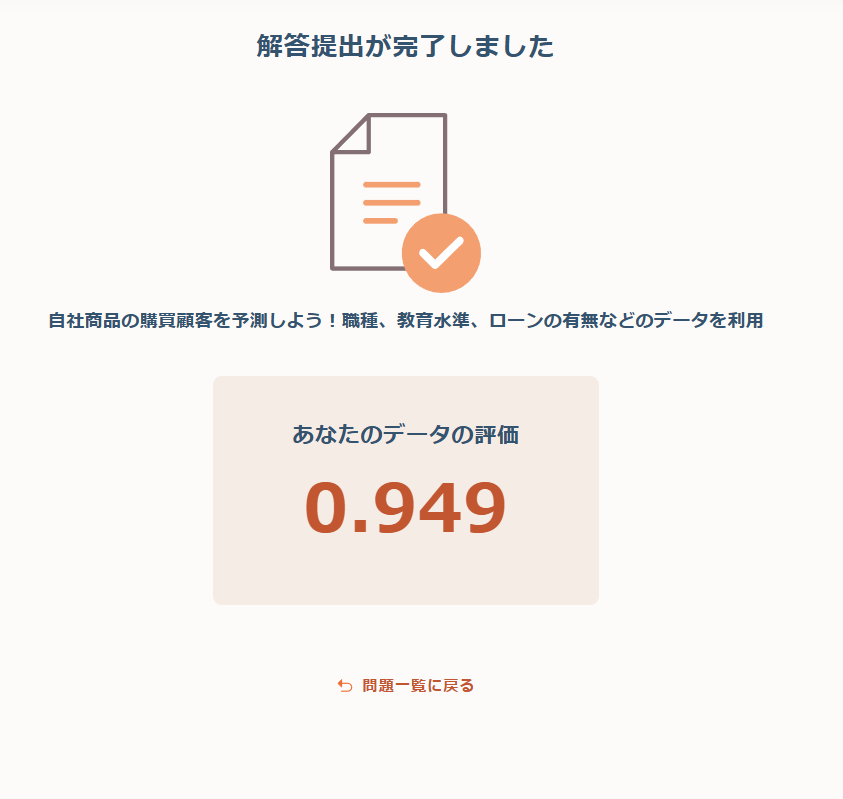